# Sentiment classification task

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle

# Language modeling

## Data

The [large movie view dataset](http://ai.stanford.edu/~amaas/data/sentiment/) contains a collection of 50,000 reviews from IMDB. The dataset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset. The dataset is divided into training and test sets. The training set is the same 25,000 labeled reviews.

The **sentiment classification task** consists of predicting the polarity (positive or negative) of a given text.

However, before we try to classify *sentiment*, we will simply try to create a *language model*; that is, a model that can predict the next word in a sentence. *Why?* Because our model first needs to understand the structure of English, before we can expect it to recognize positive vs negative sentiment.

So our plan of attack is the same as we used for Dogs v Cats: pretrain a model to do one thing (here to predict the next word), and fine tune it to do something else (classify sentiment).

Unfortunately, there are no good pretrained language models available to download, so we need to create our own. 
To follow along with this notebook, we suggest downloading the dataset from [this location](http://files.fast.ai/data/aclImdb.tgz) on files.fast.ai.

In [2]:
PATH='data/aclImdb/'

TRN_PATH = 'train/all/'
VAL_PATH = 'test/all/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

imdbEr.txt  imdb.vocab  models/  README  test/  tmp/  train/


Let's look inside the training folder...

In [3]:
trn_files = !ls {TRN}
trn_files[:5]

['0_0.txt', '0_3.txt', '0_9.txt', '10000_0.txt', '10000_4.txt']

...and at an example review.

In [4]:
review = !cat {TRN}{trn_files[6]}
review[0]

"I have to say when a name like Zombiegeddon and an atom bomb on the front cover I was expecting a flat out chop-socky fung-ku, but what I got instead was a comedy. So, it wasn't quite was I was expecting, but I really liked it anyway! The best scene ever was the main cop dude pulling those kids over and pulling a Bad Lieutenant on them!! I was laughing my ass off. I mean, the cops were just so bad! And when I say bad, I mean The Shield Vic Macky bad. But unlike that show I was laughing when they shot people and smoked dope.<br /><br />Felissa Rose...man, oh man. What can you say about that hottie. She was great and put those other actresses to shame. She should work more often!!!!! I also really liked the fight scene outside of the building. That was done really well. Lots of fighting and people getting their heads banged up. FUN! Last, but not least Joe Estevez and William Smith were great as the...well, I wasn't sure what they were, but they seemed to be having fun and throwing out 

Now we'll check how many words are in the dataset.

In [5]:
!find {TRN} -name '*.txt' | xargs cat | wc -w

17486581


In [6]:
!find {VAL} -name '*.txt' | xargs cat | wc -w

5686719


### Tokenize 
Before we can analyze text, we must first *tokenize* it. This refers to the process of splitting a sentence into an array of words (or more generally, into an array of *tokens*).

In [7]:
' '.join(spacy_tok(review[0]))

"I have to say when a name like Zombiegeddon and an atom bomb on the front cover I was expecting a flat out chop - socky fung - ku , but what I got instead was a comedy . So , it was n't quite was I was expecting , but I really liked it anyway ! The best scene ever was the main cop dude pulling those kids over and pulling a Bad Lieutenant on them ! ! I was laughing my ass off . I mean , the cops were just so bad ! And when I say bad , I mean The Shield Vic Macky bad . But unlike that show I was laughing when they shot people and smoked dope . \n\n Felissa Rose ... man , oh man . What can you say about that hottie . She was great and put those other actresses to shame . She should work more often ! ! ! ! ! I also really liked the fight scene outside of the building . That was done really well . Lots of fighting and people getting their heads banged up . FUN ! Last , but not least Joe Estevez and William Smith were great as the ... well , I was n't sure what they were , but they seemed t

We use Pytorch's [torchtext](https://github.com/pytorch/text) library to preprocess our data, telling it to use the wonderful [spacy](https://spacy.io/) library to handle tokenization.

First, we create a torchtext *field*, which describes how to preprocess a piece of text - in this case, we tell torchtext to make everything lowercase, and tokenize it with spacy.

In [8]:
#?data.Field

In [9]:
TEXT = data.Field(lower=True, tokenize=spacy_tok)  # The torchtext 

## LanguageModelData
fastai works closely with torchtext. We create a ModelData object for language modeling by taking advantage of `LanguageModelData`, 

`Parameters:`
`PATH` is the "root" directory.
`TEXT` is the torchtext field object.
`FILES` contains the paths to the training, test, and validation sets. (Here we don't have a separate test set, so we'll just use `VAL_PATH` for that too.)
`bs` is the (usual) batch size parameter. 
`bptt` (Back-Prop-Thru-Time) break up sentences for the GPU, i.e., defines how many words are processed at a time in each mini-batch row. *More importantly, it defines how many 'layers' we will backprop through.* Making this number higher will increase time and memory requirements, but will improve the model's ability to handle long sentences.
`min_freq` gives the minimum number of times a word occurs before it is defined as unknown.

In [10]:
bs=34    #64 was too big?
bptt=52  #70was too big for the DL GPU# 
min_freq=10

The dict() constructor builds dictionaries directly from sequences of key-value pairs:

In [11]:
FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)

In [12]:
#This takes approx 14 minutes
%time md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=min_freq)

CPU times: user 13min 48s, sys: 3.7 s, total: 13min 52s
Wall time: 13min 52s


After building our `ModelData` object, it automatically fills the `TEXT` object with a very important attribute: `TEXT.vocab`. This is a *vocabulary*, which stores which words (or *tokens*) have been seen in the text, and how each word will be mapped to a unique integer id. We'll need to use this information again later, so we save it.

*(Technical note: python's standard `Pickle` library can't handle this correctly, so at the top of this notebook we used the `dill` library instead and imported it as `pickle`)*.

In [13]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))   # Save the vocabulary

Here are the: # batches; # unique tokens in the vocab; # tokens in the training set; # sentences

In [14]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(11665, 34933, 1, 20626674)

This is the start of the mapping from integer IDs to unique tokens. `itos`: 'int-to-string', `stoi`: 'string to int'

In [15]:
print(TEXT.vocab.itos[:8], "\n", TEXT.vocab.stoi['the'])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of'] 
 2


Note that in a `LanguageModelData` object there is only one item in each dataset: all the words of the text joined together.

In [16]:
md.trn_ds[0].text[:8]

['besides', 'being', 'a', 'great', 'fan', 'of', 'gary', 'cooper(capt']

torchtext will handle turning this words into integer IDs for us automatically.

In [17]:
TEXT.numericalize([md.trn_ds[0].text[:8]])

Variable containing:
 1397
  122
    6
   98
  353
    7
 1951
    0
[torch.cuda.LongTensor of size 8x1 (GPU 0)]

`LanguageModelData` object will create batches with `bs` columns, and varying sequence lengths of around (52?) tokens (that's our `bptt` parameter - *backprop through time*).   
Pytorch has a neat trick in which it randomly changes the bptt parameter, in each epoch, so each epoch gets a slightly different text.

Each batch also contains the exact same data as labels, but one word later in the text - since we're trying to always predict the next word. The labels are flattened into a 1d array.

In [18]:
#next(iter(md.trn_dl))

# Train

We have a number of parameters to set - we'll learn more about these later, but you should find these values suitable for many problems.

In [19]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

Researchers have found that large amounts of *momentum* (which we'll learn about later) don't work well with these kinds of *RNN* models, so we create a version of the *Adam* optimizer with less momentum than it's default of `0.9`.
Per JH, this line probably should be included on all NLP projects

In [20]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

`fastai` uses a variant of the state of the art [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182) developed by Stephen Merity. A key feature of this model is that it provides excellent regularization through [Dropout](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout). There is no simple way known (yet!) to find the best values of the dropout parameters below - you just have to experiment...

However, the other parameters (`alpha`, `beta`, and `clip`) shouldn't generally need tuning.
`learner.clip` is a great trick to prevent gradients from exploding

In [21]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

JH gradually tuned the language model in a few stages. He could have trained it further (it wasn't yet overfitting), but didn't have time to experiment more. Maybe we can train it to a better accuracy! 
(JH used `lr_find` to find a good learning rate (`3e-3`), but didn't save the output here.) 

### 3.1 Find learn rate

In [22]:
%time learner.lr_find()

A Jupyter Widget

 83%|████████▎ | 9726/11665 [09:00<01:47, 17.98it/s, loss=20.8]CPU times: user 7min 33s, sys: 1min 47s, total: 9min 20s
Wall time: 9min


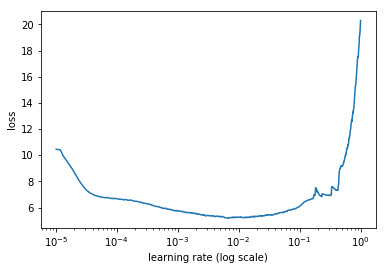

In [23]:
learner.sched.plot(10)  #100

In [24]:
%time learner.fit(3e-3, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

A Jupyter Widget

  1%|▏         | 162/11665 [00:09<10:53, 17.61it/s, loss=9.53]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/german/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/german/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/german/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                  
    0      4.893357   4.759923  
    1      4.739978   4.58527                                   
    2      4.600484   4.48423                                   
    3      4.672079   4.538454                                  
    4      4.601705   4.456753                                  
    5      4.51676    4.38596                                   
    6      4.445456   4.363559                                  
    7      4.630913   4.490603                                  
    8      4.579504   4.464695                                  
    9      4.556689   4.430359                                  
    10     4.522144   4.391323                                  
    11     4.491387   4.354424                                  
    12     4.448001   4.323299                                  
    13     4.419352   4.304399                                  
    14     4.373604   4.300255                           

[4.3002548]

In [25]:
learner.save_encoder('adam1_enc')

In [26]:
learner.load_encoder('adam1_enc')

In [27]:
#%time learner.load_cycle('adam3_10',2)

In [28]:
%time learner.fit(3e-3, 1, wds=1e-6, cycle_len=10)    # This may take 2 hours to complete

A Jupyter Widget

epoch      trn_loss   val_loss                                  
    0      4.564592   4.454609  
    1      4.583159   4.442703                                  
    2      4.559268   4.423481                                  
    3      4.50234    4.393949                                  
    4      4.490383   4.362558                                  
    5      4.437174   4.332557                                  
    6      4.424285   4.306544                                  
    7      4.365785   4.285479                                  
    8      4.362216   4.274869                                  
    9      4.37292    4.272623                                  

CPU times: user 1h 41min 36s, sys: 23min 54s, total: 2h 5min 31s
Wall time: 2h 1min 28s


[4.2726226]

In [29]:
learner.save_encoder('adam3_10_enc')

In the sentiment analysis section, we'll just need half of the language model - the *encoder*, so we save that part.

In [30]:
learner.save_encoder('adam3_20_enc')

In [31]:
learner.load_encoder('adam3_20_enc')

Language modeling accuracy is generally measured using the metric *perplexity*, which is simply `exp()` of the loss function we used.

In [32]:
math.exp(4.278112)

72.10417872771527

In [33]:
%time learner.fit(3e-3, 1, wds=1e-6, cycle_len=1)    # Keep going?

A Jupyter Widget

epoch      trn_loss   val_loss                                  
    0      4.432525   4.306206  

CPU times: user 10min 10s, sys: 2min 23s, total: 12min 34s
Wall time: 12min 10s


[4.3062062]

In [34]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

### Test

We can play around with our language model a bit to check it seems to be working OK. First, let's create a short bit of text to 'prime' a set of predictions. We'll use our torchtext field to numericalize it so we can feed it to our language model.

In [35]:
m=learner.model
ss=""". So, it wasn't quite was I was expecting, but I really liked it anyway! The best"""
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

". So , it was n't quite was I was expecting , but I really liked it anyway ! The best"

We haven't yet added methods to make it easy to test a language model, so we'll need to manually go through the steps.

In [36]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

Let's see what the top 10 predictions were for the next word after our short text:

In [37]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['<eos>',
 'of',
 'performance',
 'scene',
 'part',
 'line',
 'movie',
 'friend',
 '.',
 'film']

...and let's see if our model can generate a bit more text all by itself!

In [38]:
print(ss,"\n")
for i in range(50):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

. So, it wasn't quite was I was expecting, but I really liked it anyway! The best 

<eos> i saw this movie at the cinema in the late 70 's and i was very disappointed . i was n't expecting much from this movie , but i was very disappointed . the acting was terrible , the story was so bad , it was so bad that ...


### Sentiment

We'll need to the saved vocab from the language model, since we need to ensure the same words map to the same IDs.

In [39]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

`sequential=False` tells torchtext that a text field should be tokenized (in this case, we just want to store the 'positive' or 'negative' single label).

`splits` is a torchtext method that creates train, test, and validation sets. The IMDB dataset is built into torchtext, so we can take advantage of that. Take a look at `lang_model-arxiv.ipynb` to see how to define your own fastai/torchtext datasets.

In [40]:
IMDB_LABEL = data.Field(sequential=False)
splits = torchtext.datasets.IMDB.splits(TEXT, IMDB_LABEL, 'data/')

In [41]:
t = splits[0].examples[0]

In [42]:
t.label, ' '.join(t.text[:16])

('pos',
 'the story is about ankush ( abhay deol ) - who is professional marriage witness ,')

fastai can create a ModelData object directly from torchtext splits. (Per JH)

In [43]:
#??TextData.from_splits
#??get_rnn_classifier

In [44]:
%time md2 = TextData.from_splits(PATH, splits, bs)

CPU times: user 73.1 ms, sys: 0 ns, total: 73.1 ms
Wall time: 72.7 ms


In [45]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam3_20_enc')

Because we're fine-tuning a pretrained model, we'll use differential learning rates, and also increase the max gradient for clipping, to allow the SGDR to work better.

In [46]:
??get_rnn_classifer

In [47]:
m3.clip=25.
lrs=np.array([1e-4,1e-3,1e-2])

In [48]:
from fastai.lm_rnn import *
from fastai.learner import *

In [49]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      1.147405   1.107113   0.370668  



A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.492702   0.352583   0.912845  



[0.35258338, 0.91284512784205329]

In [50]:
%time m3.fit(lrs, 7, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb2')

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.459754   0.340428   0.921168  
    1      0.408721   0.310171   0.927491                    
    2      0.40205    0.319153   0.92401                     
    3      0.383912   0.303645   0.928451                    
    4      0.409642   0.30937    0.92445                     
    5      0.356762   0.291922   0.927931                    
    6      0.378476   0.289635   0.929652                    
    7      0.374587   0.300185   0.92473                     
    8      0.373636   0.317857   0.926811                    
    9      0.35771    0.3037     0.930052                    
    10     0.40926    0.3296     0.920448                    
    11     0.402326   0.317932   0.92441                     
    12     0.704012   0.496859   0.879032                    
    13     0.658723   0.486256   0.894958                    

CPU times: user 32min 29s, sys: 3min 19s, total: 35min 49s
Wall time: 35min 28s


[0.48625579, 0.89495797481666617]

In [51]:
m3.load_cycle('imdb2', 4)

In [53]:
accuracy_np(*m3.predict_with_targs())   #was just accuracy but redefined for the right argument type.

0.9298519407763105

In [ ]:
## Compare with other results

A recent paper from Bradbury et al, [Learned in translation: contextualized word vectors](https://einstein.ai/research/learned-in-translation-contextualized-word-vectors), has a handy summary of the latest academic research in solving this IMDB sentiment analysis problem. 
Many of the latest algorithms shown are tuned for this specific problem.

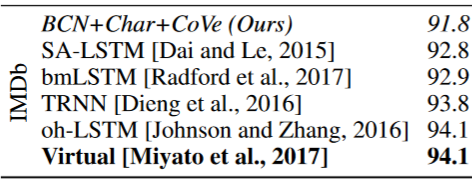

As you see, we just got a new state of the art result in sentiment analysis, decreasing the error from 5.9% to 5.5%! You should be able to get similarly world-class results on other NLP classification problems using the same basic steps.

There are many opportunities to further improve this, although we won't be able to get to them until part 2 of this course...

# End